In [1]:
"""
Backtracking Search Optimization Algorithm (BSA)
Platform: Matlab 2013a   
Cite this algorithm as;
[1]  P. Civicioglu, "Backtracking Search Optimization Algorithm for 
numerical optimization problems", Applied Mathematics and Computation,
219, 8121-8144, 2013.
Copyright Notice
Copyright (c) 2012, Pinar Civicioglu
All rights reserved.
Redistribution and use in source and binary forms, with or without 
modification, are permitted provided that the following conditions are 
met:
    * Redistributions of source code must retain the above copyright 
      notice, this list of conditions and the following disclaimer.
    * Redistributions in binary form must reproduce the copyright 
      notice, this list of conditions and the following disclaimer in 
      the documentation and/or other materials provided with the distribution
      
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" 
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE 
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE 
ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE 
LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR 
CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF 
SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS 
INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN 
CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) 
ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE 
POSSIBILITY OF SUCH DAMAGE.
"""

'\nBacktracking Search Optimization Algorithm (BSA)\nPlatform: Matlab 2013a   \nCite this algorithm as;\n[1]  P. Civicioglu, "Backtracking Search Optimization Algorithm for \nnumerical optimization problems", Applied Mathematics and Computation,\n219, 8121-8144, 2013.\nCopyright Notice\nCopyright (c) 2012, Pinar Civicioglu\nAll rights reserved.\nRedistribution and use in source and binary forms, with or without \nmodification, are permitted provided that the following conditions are \nmet:\n    * Redistributions of source code must retain the above copyright \n      notice, this list of conditions and the following disclaimer.\n    * Redistributions in binary form must reproduce the copyright \n      notice, this list of conditions and the following disclaimer in \n      the documentation and/or other materials provided with the distribution\n      \nTHIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" \nAND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT L

In [2]:
import numpy as np
import time
from datetime import timedelta

### Functions for BSA

In [3]:
def generate_population(popsize, dim, low, up):
    """
    Generates a random population
    """
    pop = np.zeros((popsize, dim))
    for i in range(popsize):
        pop[i,:] = np.random.rand(1, dim)*(up - low) + low
        
    return pop


In [4]:
def boundary_control(pop, low, up):
    """
    Controls the boundary to stay between low and up
    """
    popsize, dim = pop.shape
    for i in range(popsize):
        for j in range(dim):
            k = np.random.rand() < np.random.rand() # you can change boundary-control strategy
            if pop[i,j] < low[j]:
                if k:
                    pop[i,j] = low[j]
                else:
                    pop[i,j] = np.random.rand()*(up[j] - low[j]) + low[j]
                    
            if pop[i,j] > up[j]:
                if k:
                    pop[i,j] = up[j]
                else:
                    pop[i,j] = np.random.rand()*(up[j] - low[j]) + low[j]
    
    return pop


In [5]:
def feval(fnc, pop):
    """
    Iterates over pop and sends the cost
    of each individual of the population
    """
    cost = np.zeros((pop.shape[0]))
    for idx, p in enumerate(pop):
        cost[idx] = fnc(p)
    
    return cost


In [6]:
def convert_time(s):
    """
    Provided a time 's' in seconds,
    this method converts to a string
    in a format hh:mm:ss
    """
    hours, remainder = divmod(s, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))


# Backtracking Search Optimization Algorithm (BSA)

In [7]:
def bsa(fnc, bounds, popsize=32, epoch=100):
    """Backtracking Search Optimization Algorithm (BSA)

    Args:
        fnc (method): insert your objective function
        bounds (nested tuple): bounds as ((a, b), (c, d), (e, f))
            the first index of the nested tuple is for the lower bound
            and the last for the upper bound of the variable
        popsize (int, optional): size of the population. Defaults to 32.
        epoch (int, optional): amount of iterations. Defaults to 100.
            epoch*popsize equals to the number of objective function evaluations

    Returns:
        results (object):
            results.x is the globalminimizer array,
                i.e., optimum values for the variables
            results.y is the globalminimum scalar,
                i.e., the optimum cost with the variables results.x
            results.convergence shows the history of the results.y
    """
    
    # INITIALIZATION
    DIM_RATE = 1
    low, up = np.zeros((len(bounds))), np.zeros((len(bounds)))
    for idx, b in enumerate(bounds):
        low[idx] = b[0]
        up[idx] = b[1]
    
    dim = len(bounds)
    
    pop = generate_population(popsize, dim, low, up) # see Eq.1 in [1]
    fitnesspop = feval(fnc, pop)
    historical_pop = generate_population(popsize, dim, low, up) # see Eq.2 in [1]

    # historical_pop  is swarm-memory of BSA as mentioned in [1].
    
    # ------------------------------------------------------------------------------------------
    elapsed_time = 0
    cost_history = np.zeros((epoch))
    for epk in range(epoch):
        start = time.time()
        # SELECTION-I
        if np.random.rand() < np.random.rand():
            historical_pop = pop  # see Eq.3 in [1]
        
        historical_pop = historical_pop[np.random.permutation(popsize), :] # see Eq.4 in [1]
        
        F = 3*np.random.standard_normal() # see Eq.5 in [1], you can other F generation strategies 
        map_ = np.zeros((popsize, dim)) # see Algorithm-2 in [1]
          
        if np.random.rand() < np.random.rand():
            for i in range(popsize):
                u = np.random.permutation(dim)
                map_[i, u[np.arange(0, np.ceil(DIM_RATE*np.random.rand()*dim), dtype='int32')]] = 1
        else:
            for i in range(popsize):
                map_[i, np.random.randint(dim)] = 1
        
        # RECOMBINATION (MUTATION+CROSSOVER)
        offsprings = pop + (map_*F)*(historical_pop - pop) # see Eq.5 in [1]
        offsprings = boundary_control(offsprings, low, up) # see Algorithm-3 in [1]
        
        # SELECTON-II
        fitnessoffsprings = feval(fnc,offsprings)
        ind = fitnessoffsprings < fitnesspop
        fitnesspop[ind] = fitnessoffsprings[ind]
        pop[ind,:] = offsprings[ind,:]
        globalminimum = np.min(fitnesspop)
        cost_history[epk] = globalminimum
        ind = fitnesspop == globalminimum
        globalminimizer = pop[ind,:]
        globalminimizer = globalminimizer[0,:]
        
        # Calculate reamining time
        porcentagem = (epk/epoch)*100
        end = time.time()
        if porcentagem % 50 == 0:
            duration = end - start
            total_time = duration * epoch
            elapsed_time = duration * epk
            remaining_time = total_time - elapsed_time
            
            # print(f'Best = {globalminimum:20.8f}   ###   ( {porcentagem:3.0f}% completed ): '
            #       f'Elapsed time {convert_time(elapsed_time)} -- '  
            #       f'Reamining time {convert_time(remaining_time)} -- '
            #       f'Predicted time {convert_time(total_time)}')
    
    class results:
        x = globalminimizer
        y = globalminimum
        convergence = cost_history
    
    return results

# Test BSA

Run 00 ---> Best =     3531524.31227925; x* = [11  1 13  8  1  7 12]; 1500 generations; 12 individuals
Run 01 ---> Best =     3531524.31227925; x* = [11  1 13  8  1  7 12]; 1500 generations; 12 individuals
Run 02 ---> Best =     3532541.55622195; x* = [12  1 13  7  1  6 12]; 1500 generations; 12 individuals
Run 03 ---> Best =     3531524.31227925; x* = [11  1 13  8  1  7 12]; 1500 generations; 12 individuals
Run 04 ---> Best =     3541399.42059822; x* = [11  1 13  6  1  9 12]; 1500 generations; 12 individuals
Run 05 ---> Best =     3531524.31227925; x* = [11  1 13  8  1  7 12]; 1500 generations; 12 individuals
Run 06 ---> Best =     3531524.31227925; x* = [11  1 13  8  1  7 12]; 1500 generations; 12 individuals
Run 07 ---> Best =     3531524.31227925; x* = [11  1 13  8  1  7 12]; 1500 generations; 12 individuals
Run 08 ---> Best =     3532541.55622195; x* = [12  1 13  7  1  6 12]; 1500 generations; 12 individuals
Run 09 ---> Best =     3532541.55622195; x* = [12  1 13  7  1  6 12]; 150

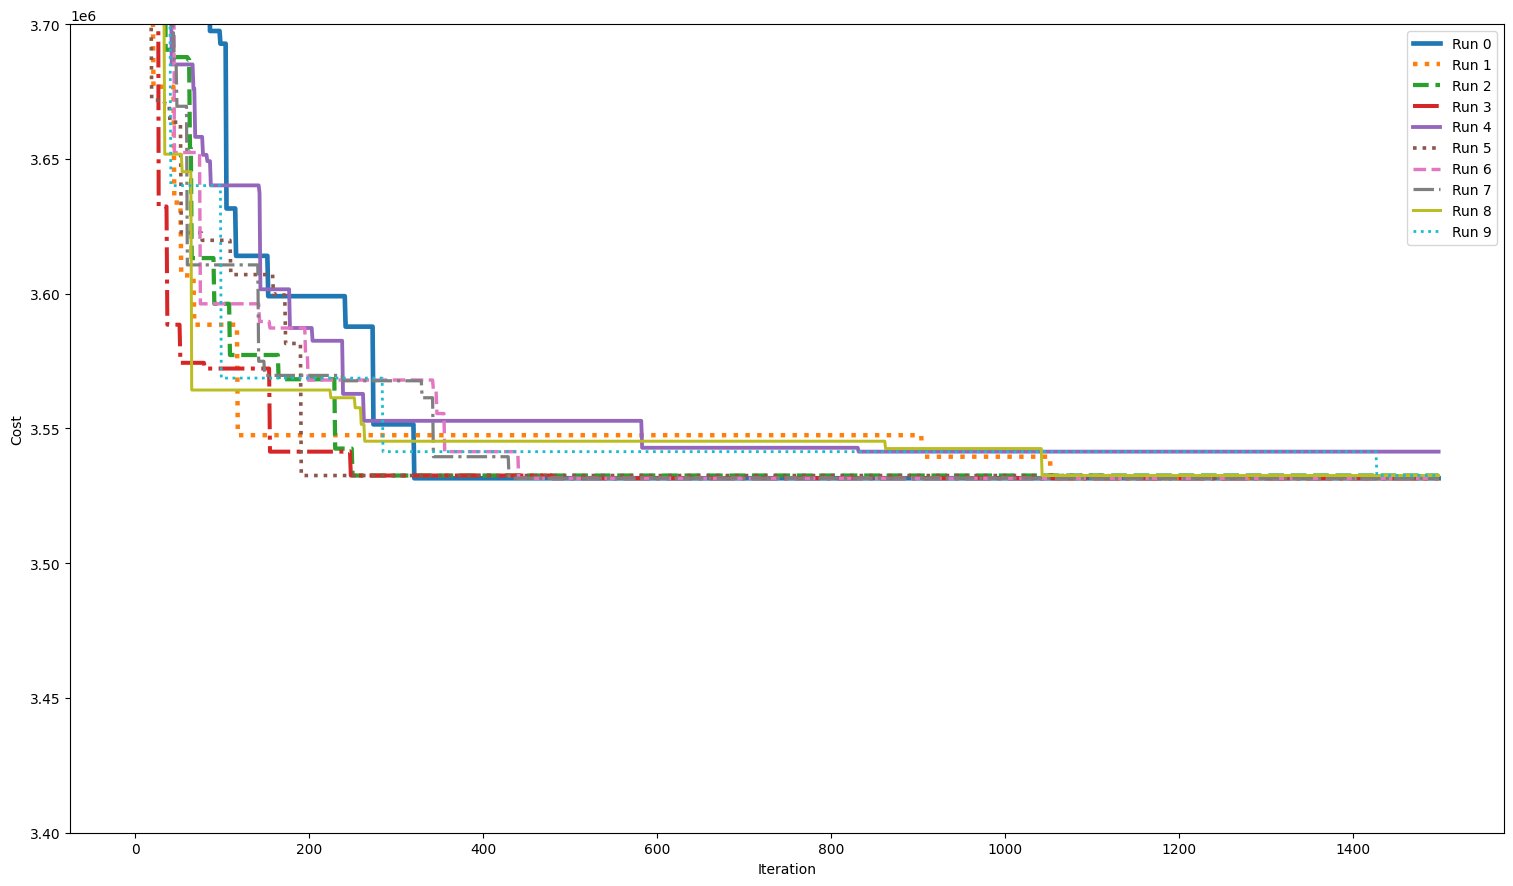

In [8]:
from trelica_2D import trelica
import matplotlib.pyplot as plt

# SET BSA PARAMETERS
bounds = (1, 13), (1, 13), (1, 13), (1, 13), (1, 13), (1, 13), (1, 13)
popsize = 12 # number of population (popsize*epoch = number of obj. func. evaluations)
epoch = 1500 # number of iterations (generations) of BSA
n = 10 # number of runs (independent of BSA)

# Some variables for the loop below
line_style = [
    'solid',   # Same as (0, ()) or '-'
    'dotted',  # Same as (0, (1, 1)) or ':'
    'dashed',  # Same as '--'
    'dashdot', # Same as '-.'
    ]

best = np.inf
worst = -np.inf
leg = []

# Run BSA n times
class runs:
    y = np.zeros((n))
    x = np.zeros((n, len(bounds)))
    convergence = np.zeros((n, epoch))

for run in range(n):
    results = bsa(trelica, bounds, popsize=popsize, epoch=epoch)

    runs.y[run] = results.y
    runs.x[run, :] = results.x
    runs.convergence[run, :] = results.convergence
    
    if results.y < best:
        best = results.y
        x_best = results.x
        best_convergence = results.convergence
    
    if results.y > worst:
        worst = results.y
    
    print(f'Run {run:02.0f} ---> Best = {results.y:20.8f}; x* = {np.array(results.x, dtype="int32")}; '
          f'{epoch} generations; {popsize} individuals')
    
    leg.append('Run ' + str(run))
    # Plot convergence
    plt.plot(np.arange(results.convergence.shape[0]), results.convergence, linestyle=line_style[run%len(line_style)], linewidth=3.35-run*0.15)

# Print best result of all n runs
print(f'Best of all {n} runs: {best}; x* = {np.array(x_best, dtype="int32")} --> Best was achieved {np.sum(runs.y == best)} out of {n} time(s)')
print(f'For {n} runs --- Mean: {np.mean(runs.y)}; Std: {np.std(runs.y)}; '
      f'Max/Min %: {(np.max(runs.y)/np.min(runs.y) - 1)*100}%; Min: {np.min(runs.y)}; Max: {np.max(runs.y)}')

# Limit plot for best visualization
log = np.log10(best)
logw = np.log10(worst)
ymin = np.round(best/(10**np.floor(log)), decimals=1)*(10**np.floor(log)) - 0.10*(10**np.floor(log))
ymax = np.round(worst/(10**np.floor(logw)), decimals=1)*(10**np.floor(logw)) + 0.20*(10**np.floor(logw))
plt.ylim([ymin, ymax])

# Labels and legend
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend(leg)

# Set figure size and save
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig(f'BSA_{n}runs_{popsize}pop_{epoch}iter.png', dpi=300)

# Best of all runs: 3531524.3122792495; x* = [11  1 13  8  1  7 12]


# Save BSA results

In [28]:
import pandas as pd
import sqlite3 as sq

cols = ['niter', 'popsize', 'fobj']

xn = lambda nx: 'x' + str(nx)
xs = list(map(xn, np.arange(runs.x.shape[1], dtype='int32')))

cols += xs

data = pd.DataFrame(np.concatenate((np.tile(epoch, (n, 1)), np.tile(popsize, (n, 1)),
                                    np.array([runs.y]).T, runs.x), axis=1),
                                    columns = cols)

filename = 'BSA.db'
table_name = 'BSA'
conn = sq.connect(filename) # creates file, if not exists

data.to_sql(name=table_name, con=conn, if_exists='append')

conn.close() # good practice: close connection


In [29]:
# Let only unique values in the database
conn = sq.connect(filename)
df = pd.read_sql_query("SELECT " + ", ".join(cols) + " from " + table_name, conn)

df_unique = df.drop_duplicates()

df_unique.to_sql(name=table_name, con=conn, if_exists='replace')

conn.close()

In [31]:
# READ DATABASE
conn = sq.connect(filename)
df = pd.read_sql_query("SELECT " + ", ".join(cols) + " from " + table_name, conn)
conn.close()
df

,niter,popsize,fobj,x0,x1,x2,x3,x4,x5,x6
0,1500.0,12.0,3.531524e+06,11.600257,1.818427,13.0,8.896966,1.000000,7.300175,12.439730
1,1500.0,12.0,3.531524e+06,11.057661,1.233415,13.0,8.946515,1.039071,7.895581,12.038367
2,1500.0,12.0,3.532542e+06,12.630709,1.649763,13.0,7.694617,1.388851,6.737432,12.065114
3,1500.0,12.0,3.531524e+06,11.401126,1.000000,13.0,8.736289,1.017083,7.328538,12.448999
4,1500.0,12.0,3.541399e+06,11.279413,1.620924,13.0,6.695796,1.551886,9.045719,12.087307
5,1500.0,12.0,3.531524e+06,11.155887,1.440572,13.0,8.824425,1.028478,7.195949,12.409832
6,1500.0,12.0,3.531524e+06,11.765143,1.461642,13.0,8.302459,1.563813,7.890337,12.384932
7,1500.0,12.0,3.531524e+06,11.222113,1.737999,13.0,8.116405,1.000000,7.171241,12.491025
8,1500.0,12.0,3.532542e+06,12.925629,1.000000,13.0,7.020255,1.142671,6.352667,12.201294
9,1500.0,12.0,3.532542e+06,12.267846,1.716824,13.0,7.932677,1.000000,6.458302,12.132954
